+--------------------------------------+
| Train Dataset                        |
|                                      |
| 1. Data Cleaning                     |
| 2. EDA                               |
| 3. Data Preprocessing                |
| 4. Feature Engineering               |
| 5. Handling Class Imbalance (SMOTE)  |
| 6. Model Training                    |
| 7. Cross-Validation & Tuning         |
| 8. Model Evaluation                  |
| 9. Save Best Model                   |
+--------------------------------------+
                  ↓
+--------------------------------------+
| Test Dataset                         |
|                                      |
| 1. Data Cleaning                     |
| 2. Data Preprocessing                |
| 3. Load Best Model                   |
| 4. Make Predictions                  |
| 5. Evaluate Test Performance         |
| 6. Report Results                    |
+--------------------------------------+


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
!unzip /content/new_train_sample.zip
train_dataset= !unzip /content/new_test_sample.zip
pd.DataFrame(train_dataset)

Archive:  /content/new_train_sample.zip
replace new_train_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: new_train_sample.csv    


,0
0,unzip: cannot find or open /content/new_test_...


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to optimize memory usage
def optimize_memory(df, exclude_cols=[]):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        if col not in exclude_cols:
            df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Path to the training dataset
train_dataset_path = r"/content/new_train_sample.csv"

# Processing the dataset in chunks
processed_chunks = []
for chunk in pd.read_csv(train_dataset_path, chunksize=500000, low_memory=False):
    chunk = optimize_memory(chunk, exclude_cols=['IncidentGrade'])  # Exclude target column from optimization
    processed_chunks.append(chunk)

# Combine chunks into a single DataFrame
train_data = pd.concat(processed_chunks, ignore_index=True)

# Cleanup
del processed_chunks

# train dataset overview

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758418 entries, 0 to 4758417
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int32  
 1   Id                  int64  
 2   OrgId               int16  
 3   IncidentId          int32  
 4   AlertId             int32  
 5   Timestamp           object 
 6   DetectorId          int16  
 7   AlertTitle          int32  
 8   Category            object 
 9   MitreTechniques     object 
 10  IncidentGrade       object 
 11  ActionGrouped       object 
 12  ActionGranular      object 
 13  EntityType          object 
 14  EvidenceRole        object 
 15  DeviceId            int32  
 16  Sha256              int32  
 17  IpAddress           int32  
 18  Url                 int32  
 19  AccountSid          int32  
 20  AccountUpn          int32  
 21  AccountObjectId     int32  
 22  AccountName         int32  
 23  DeviceName          int32  
 24  Networ

<ipython-input-4-bb9c6e2fbe8f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='IncidentGrade', palette='Set2')


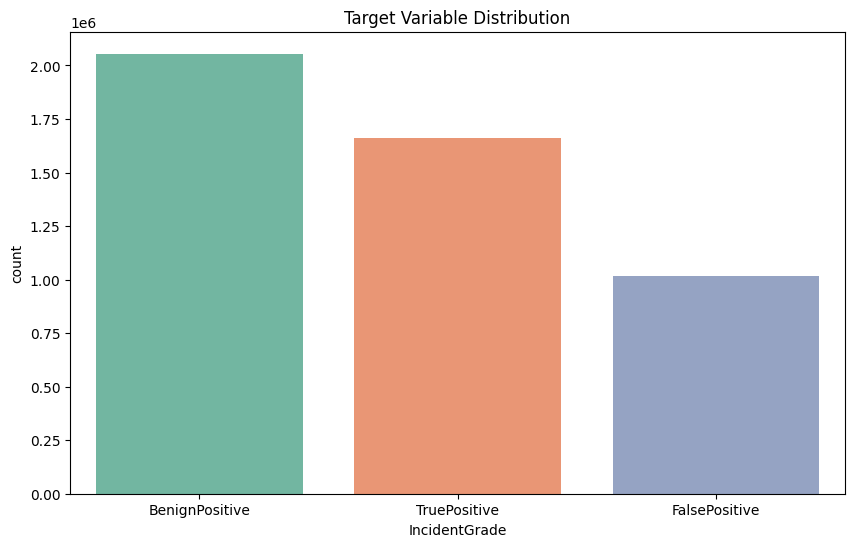

In [ ]:
# Dataset overview
print("Dataset Overview:")
print(train_data.info())

# Check for missing values
missing_values = train_data.isnull().sum()
print("\nMissing Values Summary:")
print(missing_values[missing_values > 0])

# Check for duplicate rows
duplicate_count = train_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Analyze target variable distribution
print("\nTarget Variable Distribution:")
print(train_data['IncidentGrade'].value_counts())

# Plot target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='IncidentGrade', palette='Set2')
plt.title('Target Variable Distribution')
plt.show()





## checking missing values . duplicate, imbalance data



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

file_path = '/content/new_train_sample.csv'

# Read data in chunks
chunks = pd.read_csv(file_path, chunksize=100000, low_memory=False)
df = pd.concat(chunks, ignore_index=True)

# Handle Missing Values
missing_percentage = df.isnull().sum() / len(df) * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index
print(f"Columns dropped (missing > 50%): {columns_to_drop.tolist()}")
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

# Outlier Removal
def remove_outliers(data, iqr_multiplier=1.5):
    for col in data.select_dtypes(include=['int64', 'float64']).columns:
        if data[col].nunique() > 10:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

df = remove_outliers(df)

# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour
df.drop(columns=['Timestamp'], inplace=True)

id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256',
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName',
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName',
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily', 'OSVersion', 'City','CountryCode', 'State']

numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=id_columns, errors='ignore')
scaler = MinMaxScaler()
df[numerical_features.columns] = scaler.fit_transform(numerical_features)

# Encode Categorical Features
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType','EvidenceRole']
for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))

# Remove Duplicates
df.drop_duplicates(inplace=True)

# Save Preprocessed Data
output_path = '/content/preprocessed_dataset.csv'
df.to_csv(output_path, index=False)
print(f"Data preprocessing complete. Saved to {output_path}.")


Columns dropped (missing > 50%): ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


<ipython-input-2-aa1f056f7a7d>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
<ipython-input-2-aa1f056f7a7d>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

Data preprocessing complete. Saved to /content/preprocessed_dataset.csv.


In [ ]:
df.columns

Index(['Unnamed: 0', 'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId',
       'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'DayOfWeek', 'Hour'],
      dtype='object')

In [ ]:
df.dtypes

,0
Unnamed: 0,float64
Id,int64
OrgId,int64
IncidentId,float64
AlertId,float64
DetectorId,float64
AlertTitle,float64
Category,int64
IncidentGrade,int64
EntityType,int64


**Test dataset **

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailC

<ipython-input-3-5efd74415e0e>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_data, x='IncidentGrade', palette='Set2')


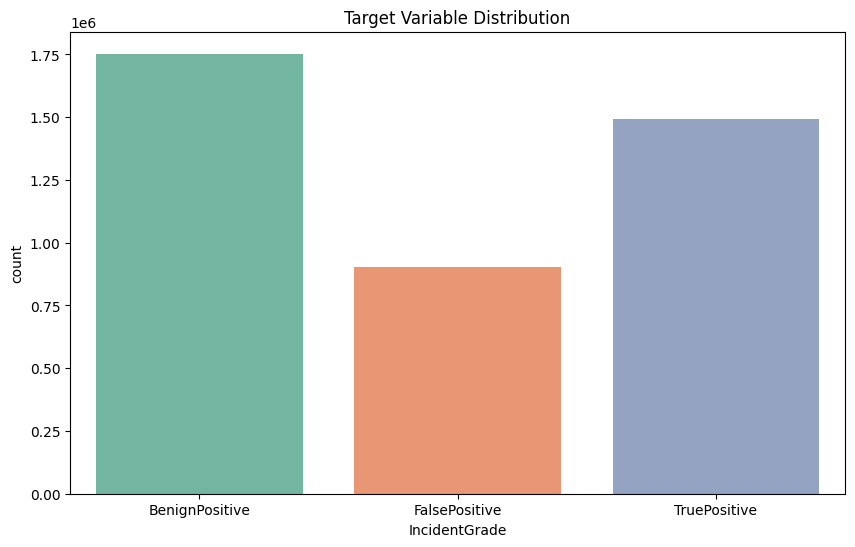

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path for test dataset
test_dataset_path = '/content/drive/MyDrive/GUIDE_Test.csv'

# Read data in chunks to handle large dataset
processed_test_chunks = []
for chunk in pd.read_csv(test_dataset_path, chunksize=100000, low_memory=False):
    processed_test_chunks.append(chunk)

# Combine all chunks into a single DataFrame
test_data = pd.concat(processed_test_chunks, ignore_index=True)

# Dataset overview
print("Dataset Overview:")
print(test_data.info())

# Check for missing values
missing_values = test_data.isnull().sum()
print("\nMissing Values Summary:")
print(missing_values[missing_values > 0])

# Check for duplicate rows
duplicate_count = test_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Analyze target variable distribution if the column `IncidentGrade` is present
if 'IncidentGrade' in test_data.columns:
    print("\nTarget Variable Distribution:")
    print(test_data['IncidentGrade'].value_counts())

    # Plot target variable distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=test_data, x='IncidentGrade', palette='Set2')
    plt.title('Target Variable Distribution')
    plt.show()
else:
    print("\nTarget column `IncidentGrade` not found in the test dataset.")





**Data Preprocessing Test dataset**


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# File path for the test dataset
test_dataset_path = '/content/GUIDE_Test.csv'

# Read data in chunks (for large datasets)
chunks = pd.read_csv(test_dataset_path, chunksize=100000, low_memory=False)
test_data = pd.concat(chunks, ignore_index=True)

# Handle Missing Values
missing_percentage = test_data.isnull().sum() / len(test_data) * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index
print(f"Columns dropped (missing > 50%): {columns_to_drop.tolist()}")
test_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns (with median)
numeric_columns = test_data.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    if test_data[col].isnull().any():
        median_val = test_data[col].median()
        test_data[col].fillna(median_val, inplace=True)

# Impute missing values for categorical columns (with mode)
categorical_columns = test_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if test_data[col].isnull().any():
        mode_val = test_data[col].mode()[0]
        test_data[col].fillna(mode_val, inplace=True)

# Outlier Removal
def remove_outliers(data, iqr_multiplier=1.5):
    for col in data.select_dtypes(include=['int64', 'float64']).columns:
        if data[col].nunique() > 10:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

test_data = remove_outliers(test_data)

# Feature Engineering (e.g., Timestamp to DateTime-related features)
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], errors='coerce')
test_data['Year'] = test_data['Timestamp'].dt.year
test_data['Month'] = test_data['Timestamp'].dt.month
test_data['DayOfWeek'] = test_data['Timestamp'].dt.dayofweek
test_data['Hour'] = test_data['Timestamp'].dt.hour
test_data.drop(columns=['Timestamp','Usage'], inplace=True)


id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256',
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName',
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName',
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily','OSVersion', 'City','CountryCode', 'State']



numerical_features = test_data.select_dtypes(include=['int64', 'float64']).drop(columns=id_columns, errors='ignore')
scaler = MinMaxScaler()
test_data[numerical_features.columns] = scaler.fit_transform(numerical_features)



# Encode Categorical Features (e.g., 'Category', 'IncidentGrade', 'EntityType')
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType','EvidenceRole']
for col in categorical_columns:
    if col in test_data.columns:
        test_data[col] = label_encoder.fit_transform(test_data[col].astype(str))


# Remove Duplicates
test_data.drop_duplicates(inplace=True)

# Save Preprocessed Test Data
output_path = '/content/preprocessed_test_dataset.csv'
test_data.to_csv(output_path, index=False)
print(f"Test dataset preprocessing complete. Saved to {output_path}.")


Columns dropped (missing > 50%): ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


<ipython-input-7-54d3cbeb86d4>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data[col].fillna(median_val, inplace=True)
<ipython-input-7-54d3cbeb86d4>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

Test dataset preprocessing complete. Saved to /content/preprocessed_test_dataset.csv.


**Feature Selection**


Top 10 Features by Importance:
        Feature  Importance
2         OrgId    0.192887
3    IncidentId    0.160661
4       AlertId    0.114151
5    DetectorId    0.107755
6    AlertTitle    0.091916
8    EntityType    0.044277
1            Id    0.038642
7      Category    0.032676
14   AccountSid    0.031629
17  AccountName    0.030031

Least Important Features:
               Feature  Importance
27          FolderPath         0.0
25  OAuthApplicationId         0.0
24     ApplicationName         0.0
23       ApplicationId         0.0
22   RegistryValueData         0.0
21   RegistryValueName         0.0
10            DeviceId         0.0
18          DeviceName         0.0
11              Sha256         0.0
19    NetworkMessageId         0.0


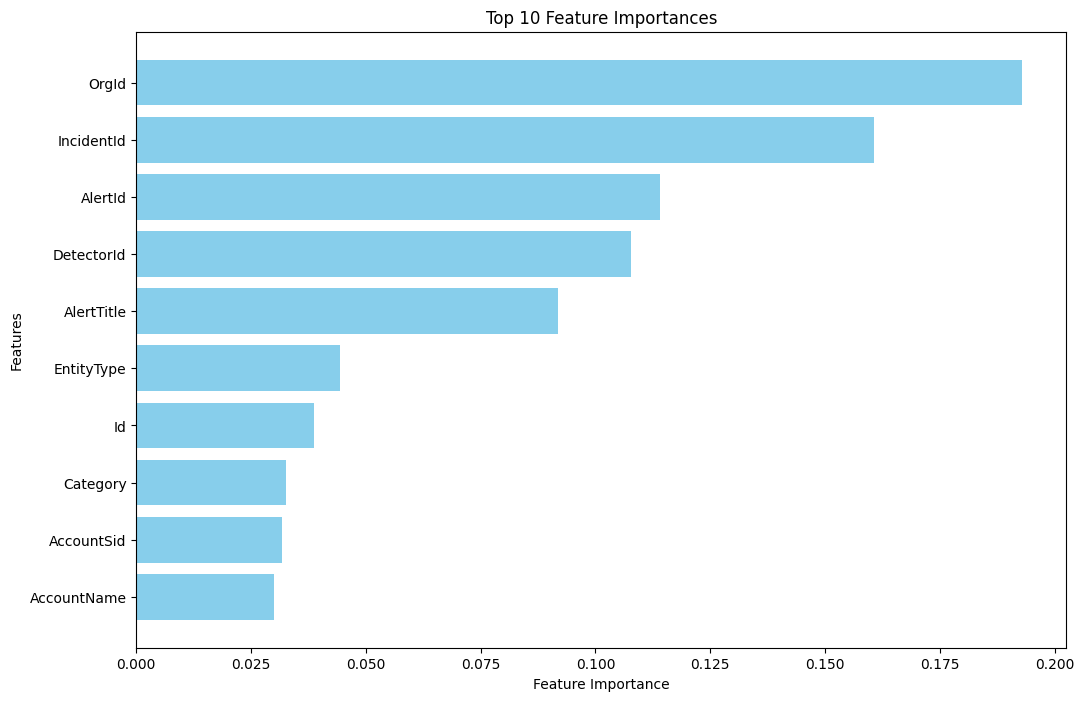

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/preprocessed_dataset.csv')
# Split features (X) and target (y)
X = df.drop(columns=["IncidentGrade"])  # Replace "IncidentGrade" with the target column name
y = df["IncidentGrade"]

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Extract feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display top and least important features
print("\nTop 10 Features by Importance:")
print(importance_df.head(10))

print("\nLeast Important Features:")
print(importance_df.tail(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances")
plt.show()

**BASE MODELS TRAINING**

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv(r"/content/preprocessed_dataset.csv")

# Encode non-numeric features
for column in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=['IncidentGrade', 'Id'])
y = df['IncidentGrade']


# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)


# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Define baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(C=100, penalty='l1', solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

# Training and evaluation on validation set
for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred))
    print(f"{name} Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Training Logistic Regression...
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.52      0.55     11599
           1       0.57      0.60      0.59     11599
           2       0.70      0.74      0.72     11600

    accuracy                           0.62     34798
   macro avg       0.62      0.62      0.62     34798
weighted avg       0.62      0.62      0.62     34798

Logistic Regression Confusion Matrix:
 [[5988 3583 2028]
 [2870 6995 1734]
 [1332 1686 8582]]

Training Decision Tree...
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     11599
           1       0.94      0.94      0.94     11599
           2       0.97      0.97      0.97     11600

    accuracy                           0.94     34798
   macro avg       0.94      0.94      0.94     34798
weighted avg       0.94      0.94      0.94     34798

De

**ADVANCED MODEL TRAINING**

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv(r"/content/preprocessed_dataset.csv")

# Encode non-numeric features
for column in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=['IncidentGrade', 'Id'])
y = df['IncidentGrade']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Define advanced models
advanced_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Training and evaluation on validation set
for name, model in advanced_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred))
    print(f"{name} Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.Regresso


Training Random Forest...
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94     11599
           1       0.96      0.96      0.96     11599
           2       0.99      0.94      0.96     11600

    accuracy                           0.96     34798
   macro avg       0.96      0.96      0.96     34798
weighted avg       0.96      0.96      0.96     34798

Random Forest Confusion Matrix:
 [[11199   313    87]
 [  396 11152    51]
 [  616    98 10886]]

Training Gradient Boosting...
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83     11599
           1       0.87      0.83      0.85     11599
           2       0.97      0.86      0.91     11600

    accuracy                           0.86     34798
   macro avg       0.87      0.86      0.86     34798
weighted avg       0.87      0.86      0.86     34798

Gra

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:37:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92     11599
           1       0.94      0.93      0.94     11599
           2       0.98      0.96      0.97     11600

    accuracy                           0.94     34798
   macro avg       0.94      0.94      0.94     34798
weighted avg       0.94      0.94      0.94     34798

XGBoost Confusion Matrix:
 [[10910   541   148]
 [  699 10825    75]
 [  408   110 11082]]

Training LightGBM...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 139190, number of used features: 18
[LightGBM] [Info] Start training from score -1.098605
[LightGBM] [Info] Start training from score -1.098605
[LightGBM] [Info] Start training from score -1.098627


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     11599
           1       0.93      0.92      0.92     11599
           2       0.98      0.94      0.96     11600

    accuracy                           0.93     34798
   macro avg       0.93      0.93      0.93     34798
weighted avg       0.93      0.93      0.93     34798

LightGBM Confusion Matrix:
 [[10804   642   153]
 [  838 10665    96]
 [  520   163 10917]]


In [11]:
df

,Unnamed: 0,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Year,Month,DayOfWeek,Hour
0,0.168584,60129543933,0,84.0,104970.0,0.0,0.000000,6,2,1,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,6,2,15
1,0.927898,1520418425476,8,9452.0,142992.0,3.0,0.033898,9,2,2,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,6,0,20
2,0.737276,455266537592,275,568.0,2817.0,1.0,0.008475,6,1,6,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,6,0,2
3,0.827344,68719477161,54,168614.0,222755.0,6.0,0.042373,6,2,2,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,6,0,21
4,0.569582,901943133951,0,204.0,185861.0,0.0,0.000000,6,2,0,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,6,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111816,0.073817,884763267171,20,985.0,1213.0,79.0,0.694915,5,0,2,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,5,1,10
111817,0.733550,884763266298,118,1997.0,151857.0,88.0,0.203390,1,0,10,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,6,0,1
111818,0.670508,773094115057,0,196.0,164404.0,0.0,0.000000,6,2,10,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,6,2,15
111819,0.514992,1185410975377,1,491.0,308162.0,0.0,0.000000,6,2,0,...,3586.0,5.0,66.0,242.0,1445.0,10630.0,2024,6,2,16


**Best model is Random Forest model with hyperparameter tuning and cross-validation for better performance**

In [37]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Load the dataset
df = pd.read_csv(r"/content/preprocessed_dataset.csv")

# Define features and target variable
X = df.drop(columns=['IncidentGrade', 'Id'])
y = df['IncidentGrade']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Standardize the features
scaler = StandardScaler()

# Initialize RandomForest model with specified parameters
rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=30,
    class_weight='balanced_subsample',
    bootstrap=True,
    random_state=42
)

# Create the Pipeline
pipeline = Pipeline(steps=[
    ('smote', smote),
    ('scaler', scaler),
    ('classifier', rf)
])

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro')

# Print cross-validation results
print("\n5-Fold Cross-Validation Scores:", cv_scores)
print("Mean CV F1-Score: {:.2f}".format(cv_scores.mean()))

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the Pipeline on training data
pipeline.fit(X_train, y_train)

# Evaluate the model on validation data
y_pred = pipeline.predict(X_val)

# Classification report and confusion matrix
print("\nRandom Forest Classification Report:\n", classification_report(y_val, y_pred))
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Save the trained model using pickle
model_filename = '/content/rf_random_forest_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)

print(f"Random Forest model saved as: {model_filename}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise a


5-Fold Cross-Validation Scores: [0.93278557 0.92886839 0.93292627 0.93312821 0.93663517]
Mean CV F1-Score: 0.93


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      6929
           1       0.93      0.91      0.92      3836
           2       0.99      0.93      0.96     11600

    accuracy                           0.94     22365
   macro avg       0.93      0.94      0.93     22365
weighted avg       0.94      0.94      0.94     22365


Random Forest Confusion Matrix:
 [[ 6721   148    60]
 [  276  3507    53]
 [  708   127 10765]]
Random Forest model saved as: /content/rf_random_forest_model.pkl


**Evaluation of Selected Random Forest Model on Test Data**

In [38]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

# Load the saved Random Forest model
model_path = r"/content/rf_random_forest_model.pkl"
best_rf = load(model_path)

# Load the test dataset
test_data_path = r"/content/preprocessed_test_dataset.csv"
test_df = pd.read_csv(test_data_path)

# Drop unexpected columns like 'Unnamed: 0' if present
if 'Unnamed: 0' in test_df.columns:
    test_df = test_df.drop(columns=['Unnamed: 0'])

# Define features and target variable
X_test = test_df.drop(columns=['IncidentGrade', 'Id'])  # Features
y_test = test_df['IncidentGrade']  # Target variable

# Get model's expected features
model_features = best_rf.feature_names_in_

# Check for missing features in the test set
missing_features = [feature for feature in model_features if feature not in X_test.columns]
if missing_features:
    print(f"Adding missing features to test set: {missing_features}")
    for feature in missing_features:
        X_test[feature] = 0  # Add missing features with default value (e.g., 0)

# Reorder test features to match model's expected order
X_test = X_test[model_features]

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))

Adding missing features to test set: ['Unnamed: 0']

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     54833
           1       0.84      0.86      0.85     35897
           2       0.98      0.91      0.95    116597

    accuracy                           0.90    207327
   macro avg       0.87      0.89      0.88    207327
weighted avg       0.91      0.90      0.90    207327


Macro-F1 Score: 0.88
Macro Precision: 0.87
Macro Recall: 0.89

Confusion Matrix on Test Data:
[[ 50027   3967    839]
 [  4187  30888    822]
 [  8521   1931 106145]]
